In [2]:
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)


export_dir = '/home/pgonzalez/Dropbox/quant_datasetshift/'
quantificators = ["CC", "ACC", "PCC", "PACC", "DyS", "EMQ","MLPE"]
error = "MAE"
ps_train = [0.25, 0.5, 0.75]
ps_test = [0.25, 0.5, 0.75]
dateexperiment = "2022_07_12_17_50"


results_dict={}
print("Loading results... ",sep="")
for quant_name in quantificators:
    results_dict[quant_name] = pd.read_csv("results/concept/results_%s_%s.csv" % (dateexperiment,quant_name),index_col=0)
    results_dict[quant_name]['MAE'] = results_dict[quant_name]['error'].abs()
    results_dict[quant_name]['cut_points'] = results_dict[quant_name]['cut_point_train']-results_dict[quant_name]['cut_point_test']
print("Done")


mean_error_methods = {}

writer = pd.ExcelWriter('results/concept/excel/errors_%s.xlsx' % dateexperiment, engine='xlsxwriter')
for p_train in ps_train:
    for p_test in ps_test:
        for quant_name in quantificators:
            exp_id = "%s_%f_%f" % (quant_name,p_train,p_test)
            results = results_dict[quant_name]
            results = results.loc[(results['p_test'] == p_test) & (results['p_train'] == p_train)]
            results_mean = results.groupby(['cut_point_train', 'cut_point_test'])['MAE'].mean().reset_index()
            #convert to matrix form
            results_mean = results_mean.pivot(index='cut_point_train', columns='cut_point_test', values='MAE')
            mean_error_methods[exp_id]=results_mean.mean().mean()
            print("Results for method %s. p_train: %f. p_test: %f. Mean %s: %f" % (quant_name,p_train, p_test,error,mean_error_methods[exp_id]))
            cm = sns.light_palette('red', as_cmap=True)
            display(results_mean.style.background_gradient(cmap=cm,low=0,high=1))
            results_mean.to_excel(writer, sheet_name=exp_id)
            workbook = writer.book
            worksheet = writer.sheets[exp_id]
            # Apply a conditional format to the cell range.
            worksheet.conditional_format('B2:D4', {'type': '2_color_scale','min_type':'num','max_type':'num','min_value':'0','max_value':'1','min_color':'#f3f0f0','max_color':'#ff0000'})
writer.close()

Loading results... 
Done
Results for method CC. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.047128


cut_point_test,2,3,4
cut_point_train,,,
2,0.011572,0.057040,0.152044
3,0.019808,0.017784,0.077972
4,0.042244,0.026656,0.019028


Results for method ACC. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.069634


cut_point_test,2,3,4
cut_point_train,,,
2,0.018064,0.088531,0.227102
3,0.032011,0.020033,0.104832
4,0.069322,0.043762,0.023047


Results for method PCC. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.042150


cut_point_test,2,3,4
cut_point_train,,,
2,0.010378,0.054775,0.136141
3,0.018366,0.010855,0.066769
4,0.041722,0.026979,0.013366


Results for method PACC. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.073377


cut_point_test,2,3,4
cut_point_train,,,
2,0.013861,0.088699,0.229267
3,0.042231,0.016592,0.109254
4,0.083885,0.056507,0.020097


Results for method DyS. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.069017


cut_point_test,2,3,4
cut_point_train,,,
2,0.014693,0.072926,0.217323
3,0.043514,0.019136,0.098437
4,0.080598,0.057091,0.017433


Results for method EMQ. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.074696


cut_point_test,2,3,4
cut_point_train,,,
2,0.012682,0.089289,0.247423
3,0.043545,0.016083,0.108771
4,0.080640,0.057195,0.016633


Results for method MLPE. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.000000


cut_point_test,2,3,4
cut_point_train,,,
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000


Results for method CC. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.074374


cut_point_test,2,3,4
cut_point_train,,,
2,0.069144,0.027084,0.048440
3,0.100688,0.068164,0.019100
4,0.149120,0.119224,0.068400


Results for method ACC. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.072407


cut_point_test,2,3,4
cut_point_train,,,
2,0.026210,0.085421,0.192396
3,0.038559,0.024714,0.103699
4,0.097919,0.052233,0.030518


Results for method PCC. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.091535


cut_point_test,2,3,4
cut_point_train,,,
2,0.087364,0.048414,0.016375
3,0.123163,0.093789,0.038957
4,0.169888,0.145174,0.100690


Results for method PACC. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.075462


cut_point_test,2,3,4
cut_point_train,,,
2,0.026132,0.090125,0.199932
3,0.039075,0.021367,0.111339
4,0.102613,0.057153,0.031419


Results for method DyS. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.072713


cut_point_test,2,3,4
cut_point_train,,,
2,0.018180,0.070294,0.181373
3,0.056337,0.020742,0.089240
4,0.120048,0.076717,0.021484


Results for method EMQ. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.077262


cut_point_test,2,3,4
cut_point_train,,,
2,0.020590,0.093327,0.209210
3,0.049702,0.016855,0.107004
4,0.109930,0.065594,0.023143


Results for method MLPE. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.250000


cut_point_test,2,3,4
cut_point_train,,,
2,0.250000,0.250000,0.250000
3,0.250000,0.250000,0.250000
4,0.250000,0.250000,0.250000


Results for method CC. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.150501


cut_point_test,2,3,4
cut_point_train,,,
2,0.144120,0.105652,0.058008
3,0.186156,0.146052,0.091832
4,0.258432,0.212596,0.151660


Results for method ACC. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.074979


cut_point_test,2,3,4
cut_point_train,,,
2,0.033016,0.082883,0.153593
3,0.046798,0.028824,0.100586
4,0.130699,0.059785,0.038628


Results for method PCC. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.198550


cut_point_test,2,3,4
cut_point_train,,,
2,0.184842,0.150830,0.107813
3,0.230150,0.194359,0.145865
4,0.300289,0.262715,0.210089


Results for method PACC. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.078256


cut_point_test,2,3,4
cut_point_train,,,
2,0.036515,0.092962,0.167515
3,0.039504,0.028953,0.111518
4,0.125789,0.056781,0.044771


Results for method DyS. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.069066


cut_point_test,2,3,4
cut_point_train,,,
2,0.018215,0.058593,0.125191
3,0.065616,0.020940,0.066524
4,0.154249,0.086817,0.025446


Results for method EMQ. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.065466


cut_point_test,2,3,4
cut_point_train,,,
2,0.021514,0.074845,0.135169
3,0.050726,0.016321,0.077006
4,0.127940,0.062303,0.023373


Results for method MLPE. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.500000


cut_point_test,2,3,4
cut_point_train,,,
2,0.500000,0.500000,0.500000
3,0.500000,0.500000,0.500000
4,0.500000,0.500000,0.500000


Results for method CC. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.097904


cut_point_test,2,3,4
cut_point_train,,,
2,0.075784,0.143332,0.248340
3,0.039860,0.075356,0.154964
4,0.021720,0.037312,0.084472


Results for method ACC. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.078686


cut_point_test,2,3,4
cut_point_train,,,
2,0.016853,0.089268,0.241120
3,0.054830,0.019602,0.110481
4,0.091347,0.063946,0.020731


Results for method PCC. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.120699


cut_point_test,2,3,4
cut_point_train,,,
2,0.100522,0.158613,0.245546
3,0.069276,0.101557,0.171436
4,0.053739,0.071370,0.114228


Results for method PACC. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.083204


cut_point_test,2,3,4
cut_point_train,,,
2,0.015686,0.090116,0.240352
3,0.062575,0.016742,0.112147
4,0.112903,0.080959,0.017358


Results for method DyS. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.073148


cut_point_test,2,3,4
cut_point_train,,,
2,0.014769,0.084532,0.234756
3,0.041641,0.016898,0.105798
4,0.084131,0.058880,0.016928


Results for method EMQ. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.074084


cut_point_test,2,3,4
cut_point_train,,,
2,0.013383,0.078002,0.238588
3,0.050661,0.016825,0.101423
4,0.088626,0.064632,0.014616


Results for method MLPE. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.250000


cut_point_test,2,3,4
cut_point_train,,,
2,0.250000,0.250000,0.250000
3,0.250000,0.250000,0.250000
4,0.250000,0.250000,0.250000


Results for method CC. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.051717


cut_point_test,2,3,4
cut_point_train,,,
2,0.014760,0.056456,0.134124
3,0.036660,0.012956,0.066484
4,0.079424,0.050768,0.013820


Results for method ACC. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.072728


cut_point_test,2,3,4
cut_point_train,,,
2,0.017426,0.077431,0.188246
3,0.056262,0.019060,0.091121
4,0.114474,0.070804,0.019729


Results for method PCC. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.043214


cut_point_test,2,3,4
cut_point_train,,,
2,0.009908,0.048635,0.113171
3,0.032091,0.009275,0.058780
4,0.066244,0.040869,0.009955


Results for method PACC. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.075729


cut_point_test,2,3,4
cut_point_train,,,
2,0.016494,0.081956,0.193758
3,0.057856,0.016355,0.097608
4,0.123182,0.076705,0.017646


Results for method DyS. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.074934


cut_point_test,2,3,4
cut_point_train,,,
2,0.018120,0.080365,0.192271
3,0.055169,0.017842,0.095010
4,0.121237,0.077322,0.017067


Results for method EMQ. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.076489


cut_point_test,2,3,4
cut_point_train,,,
2,0.016061,0.084155,0.201527
3,0.057895,0.015925,0.100357
4,0.119904,0.075142,0.017433


Results for method MLPE. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.000000


cut_point_test,2,3,4
cut_point_train,,,
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000


Results for method CC. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.081195


cut_point_test,2,3,4
cut_point_train,,,
2,0.067900,0.029836,0.019924
3,0.114936,0.075052,0.025404
4,0.180780,0.137364,0.079560


Results for method ACC. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.066446


cut_point_test,2,3,4
cut_point_train,,,
2,0.018940,0.065532,0.131597
3,0.060752,0.017293,0.068472
4,0.140957,0.074889,0.019584


Results for method PCC. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.101576


cut_point_test,2,3,4
cut_point_train,,,
2,0.095145,0.060836,0.022811
3,0.135168,0.100681,0.056093
4,0.188753,0.151413,0.103283


Results for method PACC. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.068864


cut_point_test,2,3,4
cut_point_train,,,
2,0.021143,0.074834,0.143111
3,0.055805,0.014976,0.079332
4,0.137957,0.069759,0.022863


Results for method DyS. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.066431


cut_point_test,2,3,4
cut_point_train,,,
2,0.016912,0.063382,0.125799
3,0.062344,0.016236,0.065360
4,0.148560,0.082923,0.016365


Results for method EMQ. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.064595


cut_point_test,2,3,4
cut_point_train,,,
2,0.016542,0.068743,0.129926
3,0.056185,0.013988,0.072488
4,0.136355,0.069388,0.017738


Results for method MLPE. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.250000


cut_point_test,2,3,4
cut_point_train,,,
2,0.250000,0.250000,0.250000
3,0.250000,0.250000,0.250000
4,0.250000,0.250000,0.250000


Results for method CC. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.175268


cut_point_test,2,3,4
cut_point_train,,,
2,0.139732,0.217304,0.326780
3,0.106516,0.146900,0.236704
4,0.101856,0.122444,0.179176


Results for method ACC. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.094777


cut_point_test,2,3,4
cut_point_train,,,
2,0.030581,0.089801,0.253870
3,0.076654,0.026017,0.117362
4,0.128921,0.100601,0.029189


Results for method PCC. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.220290


cut_point_test,2,3,4
cut_point_train,,,
2,0.197449,0.266318,0.358619
3,0.158887,0.198089,0.278859
4,0.144540,0.164612,0.215239


Results for method PACC. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.101458


cut_point_test,2,3,4
cut_point_train,,,
2,0.032871,0.087791,0.249123
3,0.092459,0.029394,0.115491
4,0.155506,0.119349,0.031135


Results for method DyS. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.082817


cut_point_test,2,3,4
cut_point_train,,,
2,0.021438,0.106022,0.260222
3,0.051019,0.018223,0.113201
4,0.087763,0.061525,0.025937


Results for method EMQ. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.076196


cut_point_test,2,3,4
cut_point_train,,,
2,0.021409,0.065219,0.229672
3,0.057709,0.022358,0.094745
4,0.099556,0.077550,0.017544


Results for method MLPE. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.500000


cut_point_test,2,3,4
cut_point_train,,,
2,0.500000,0.500000,0.500000
3,0.500000,0.500000,0.500000
4,0.500000,0.500000,0.500000


Results for method CC. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.084790


cut_point_test,2,3,4
cut_point_train,,,
2,0.065580,0.121516,0.201060
3,0.031704,0.066072,0.136228
4,0.014028,0.035932,0.090988


Results for method ACC. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.080081


cut_point_test,2,3,4
cut_point_train,,,
2,0.023015,0.071163,0.189238
3,0.070574,0.023266,0.090293
4,0.136014,0.094351,0.022812


Results for method PCC. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.108483


cut_point_test,2,3,4
cut_point_train,,,
2,0.098615,0.148586,0.214934
3,0.061758,0.096385,0.158878
4,0.032152,0.057865,0.107174


Results for method PACC. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.083831


cut_point_test,2,3,4
cut_point_train,,,
2,0.019132,0.075802,0.193102
3,0.075944,0.022552,0.094095
4,0.150611,0.103616,0.019623


Results for method DyS. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.077409


cut_point_test,2,3,4
cut_point_train,,,
2,0.020786,0.089771,0.202672
3,0.059040,0.018369,0.096451
4,0.114470,0.071922,0.023204


Results for method EMQ. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.078341


cut_point_test,2,3,4
cut_point_train,,,
2,0.015797,0.075379,0.196151
3,0.064515,0.019282,0.094478
4,0.133811,0.089830,0.015827


Results for method MLPE. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.250000


cut_point_test,2,3,4
cut_point_train,,,
2,0.250000,0.250000,0.250000
3,0.250000,0.250000,0.250000
4,0.250000,0.250000,0.250000


Results for method CC. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.041675


cut_point_test,2,3,4
cut_point_train,,,
2,0.018028,0.028820,0.071808
3,0.050964,0.021968,0.033540
4,0.089080,0.049384,0.011484


Results for method ACC. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.065376


cut_point_test,2,3,4
cut_point_train,,,
2,0.017924,0.053972,0.119670
3,0.066974,0.020029,0.058362
4,0.147133,0.084969,0.019352


Results for method PCC. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.037021


cut_point_test,2,3,4
cut_point_train,,,
2,0.008719,0.031749,0.068598
3,0.037289,0.010508,0.036704
4,0.082536,0.046915,0.010166


Results for method PACC. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.067941


cut_point_test,2,3,4
cut_point_train,,,
2,0.015511,0.065167,0.132609
3,0.062940,0.015788,0.068798
4,0.149986,0.084021,0.016645


Results for method DyS. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.064399


cut_point_test,2,3,4
cut_point_train,,,
2,0.016802,0.065069,0.125155
3,0.061703,0.016554,0.064736
4,0.136405,0.072990,0.020176


Results for method EMQ. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.066808


cut_point_test,2,3,4
cut_point_train,,,
2,0.014415,0.065323,0.128612
3,0.061119,0.014746,0.069538
4,0.149486,0.082497,0.015539


Results for method MLPE. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.000000


cut_point_test,2,3,4
cut_point_train,,,
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000


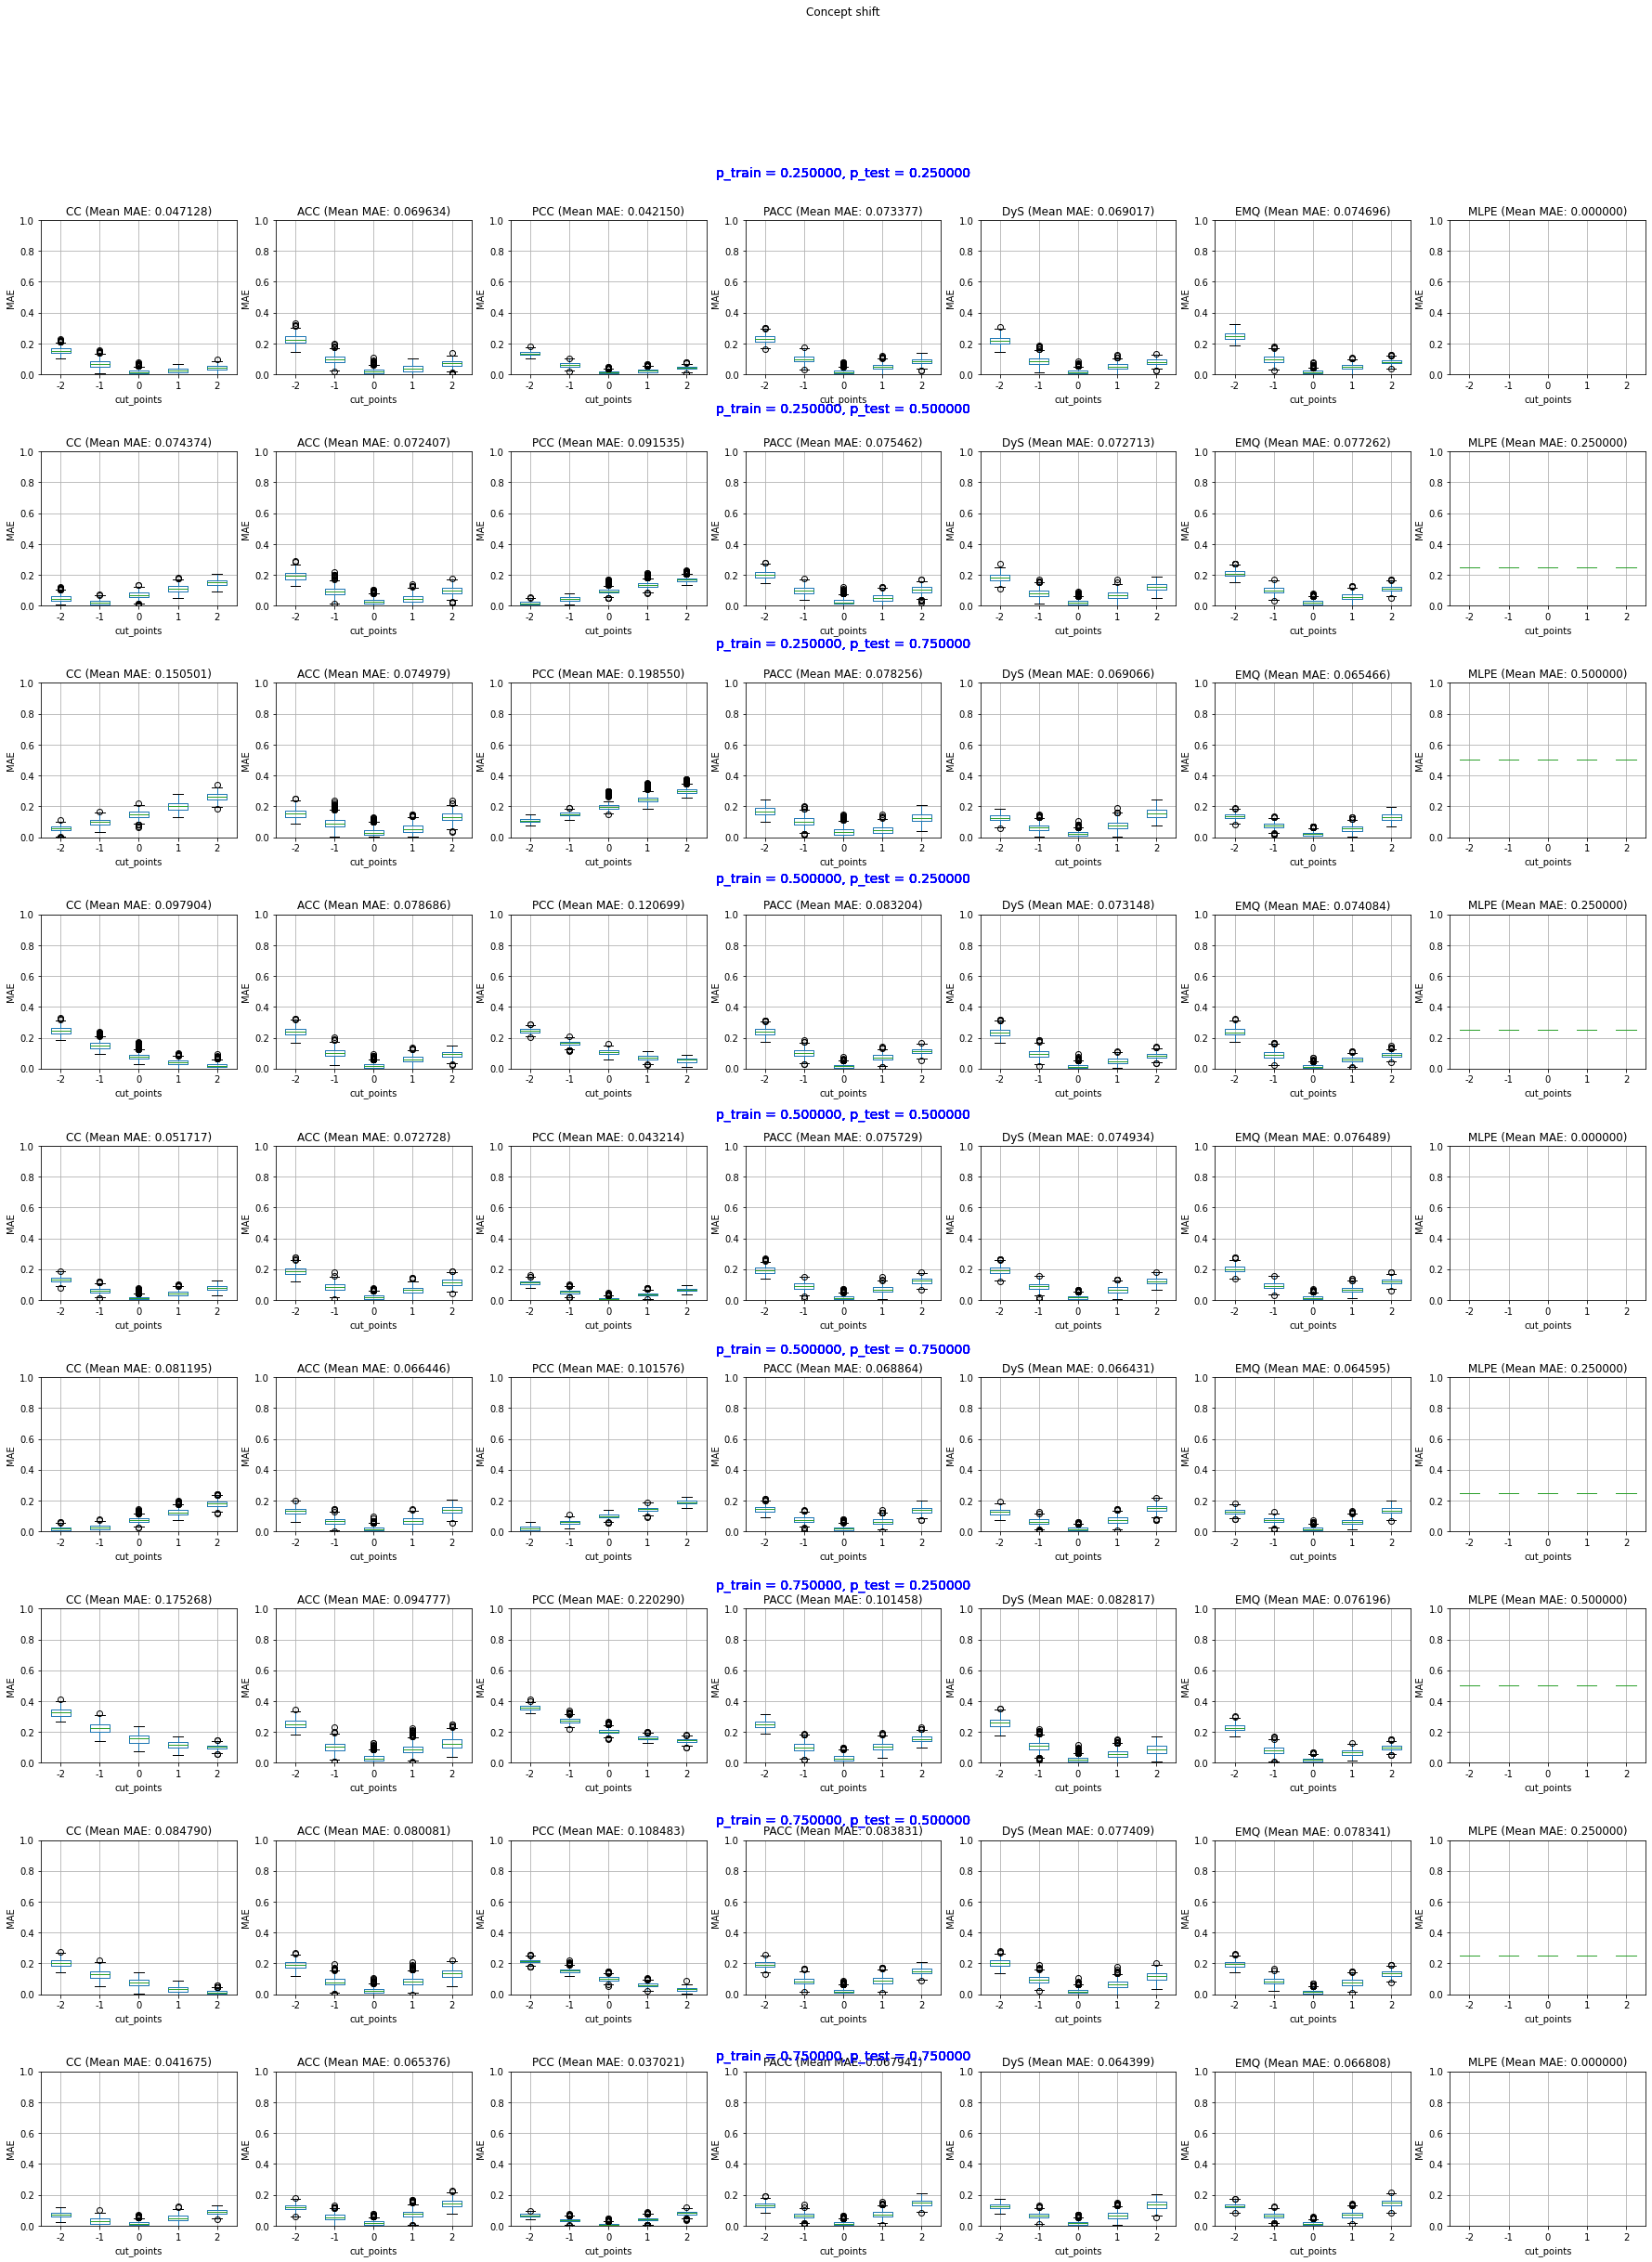

In [3]:
fig, ax = plt.subplots(len(ps_test)*len(ps_train),len(quantificators),figsize=(30,40))
plt.subplots_adjust(hspace=0.5)
for i, p_train in enumerate(ps_train):
    for j, p_test in enumerate(ps_test):
        for k,quant_name in enumerate(quantificators):
            exp_id = "%s_%f_%f" % (quant_name,p_train,p_test)
            row = i*len(ps_train)+j
            results = results_dict[quant_name]
            results = results.loc[(results['p_test'] == p_test) & (results['p_train'] == p_train)]
            ax[row][k].set_ylim(0, 1)
            ax[row][k].set_ylabel(error)
            results.boxplot(ax=ax[row][k],column='MAE',by='cut_points')
            plt.suptitle('Concept shift')
            ax[row][k].set_title("%s (Mean %s: %f)"  % (quant_name,'MAE',mean_error_methods[exp_id]))
            plt.figtext(0.5,0.92-((i*len(ps_train)+j)*0.088), "p_train = %f, p_test = %f" % (p_train,p_test), ha="center", va="top", fontsize=14, color="b")


### Tables and charts to be included in a paper

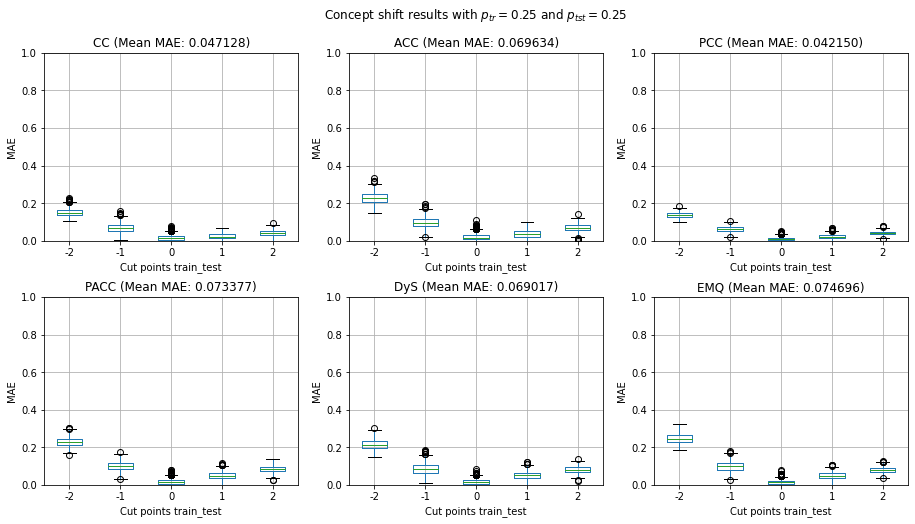

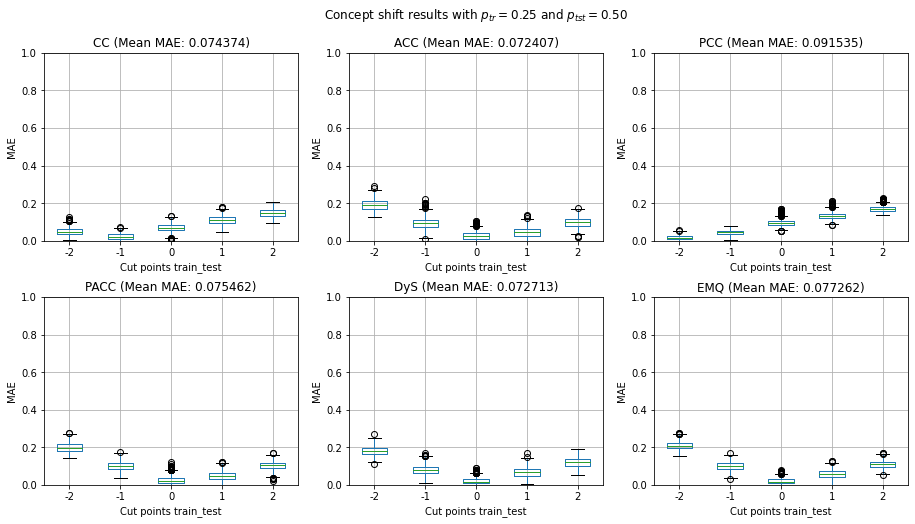

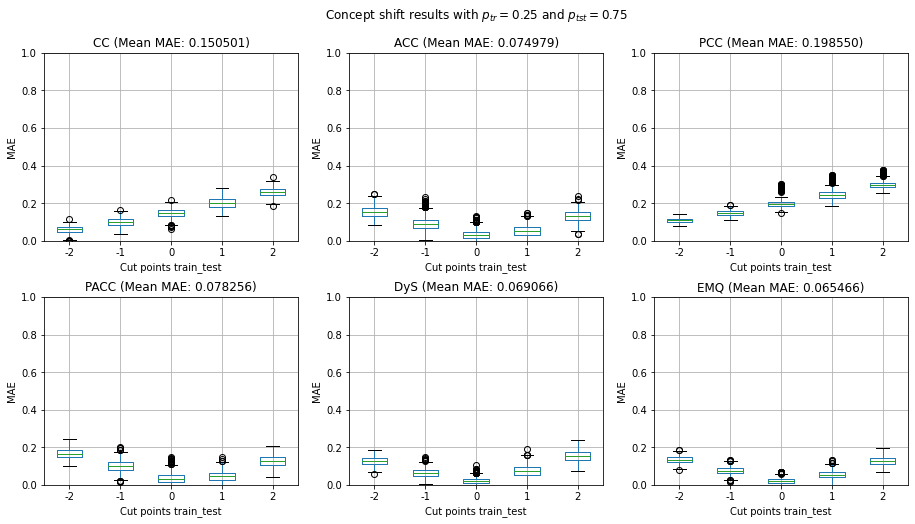

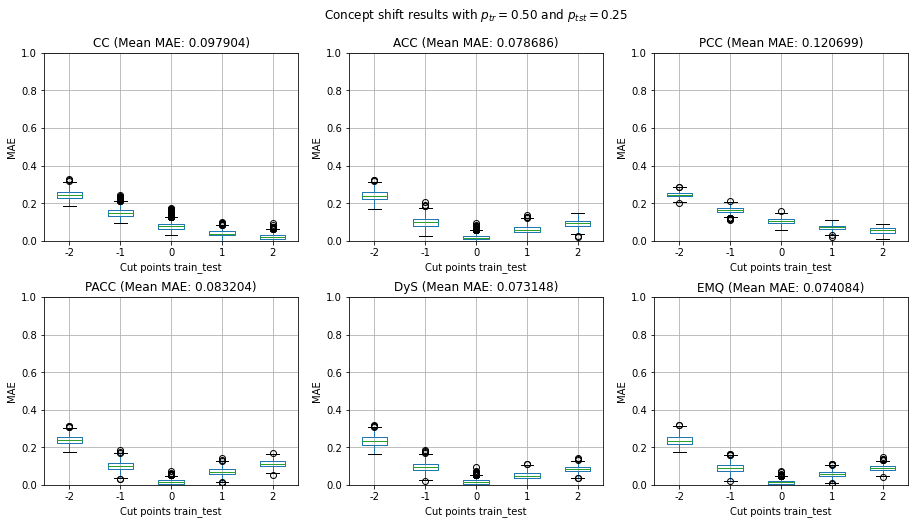

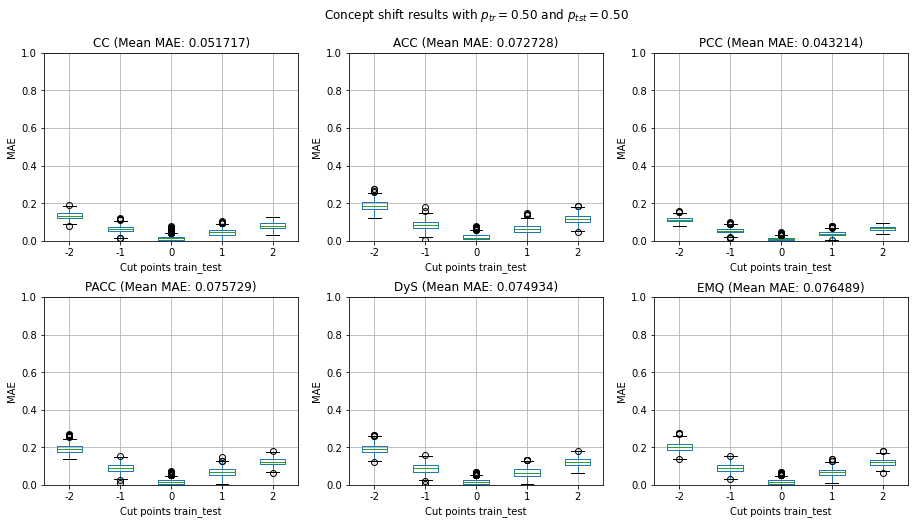

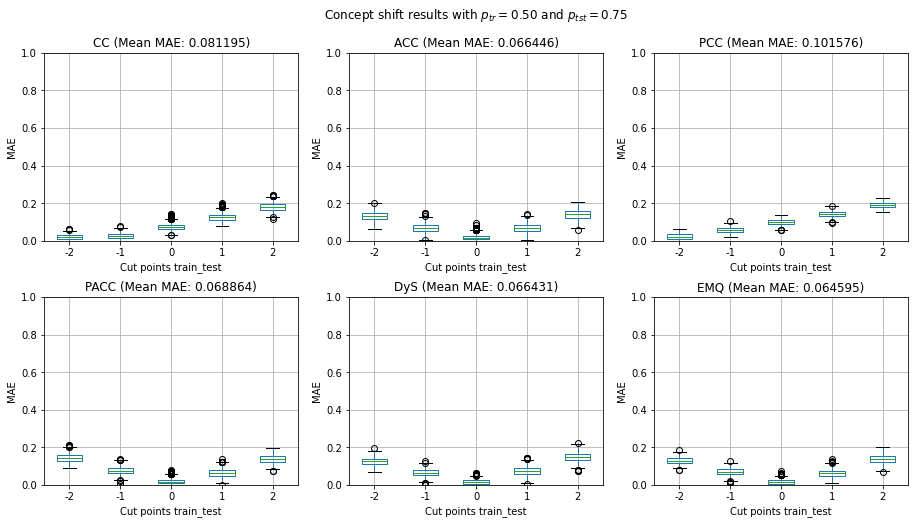

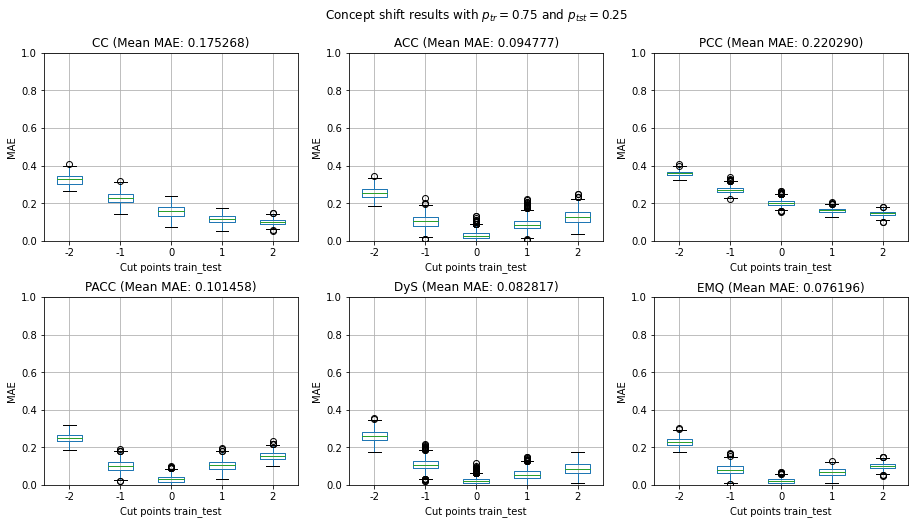

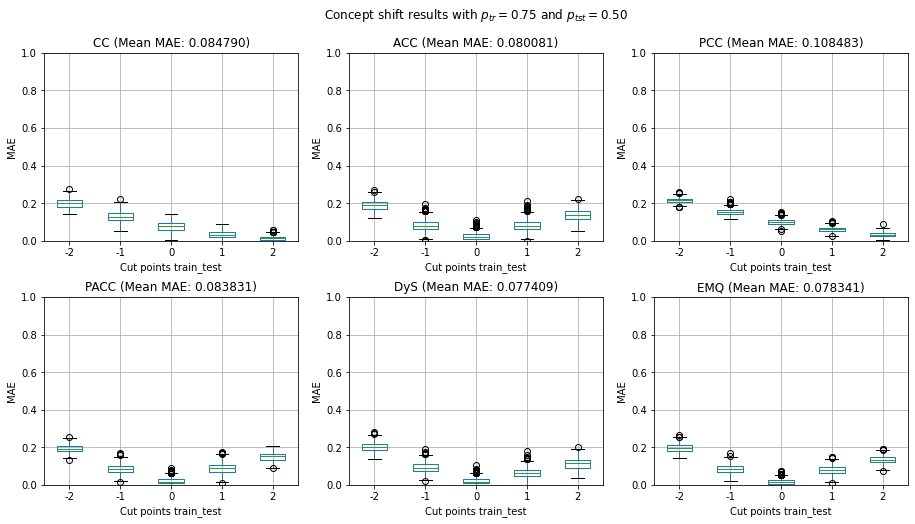

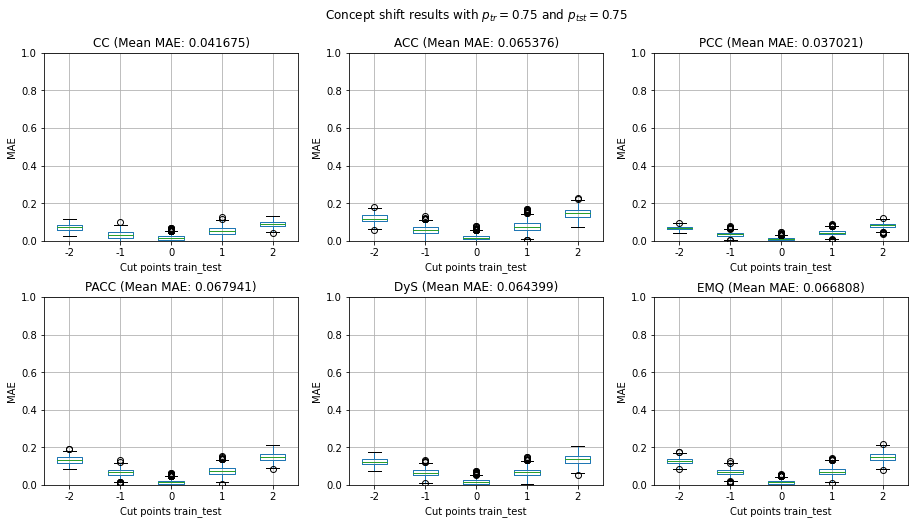

In [7]:
quantificators = ["CC", "ACC", "PCC", "PACC", "DyS", "EMQ"]
for p_train in ps_train:
    for p_test in ps_test:
        fig, ax = plt.subplots(2,3,figsize=(15,8))
        plt.subplots_adjust(hspace=0.3)
        for k,quant_name in enumerate(quantificators):
            exp_id = "%s_%f_%f" % (quant_name,p_train,p_test)
            results = results_dict[quant_name]
            results = results.loc[(results['p_test'] == p_test) & (results['p_train'] == p_train)]
            ax[k//3][k%3].set_ylim(0, 1)
            ax[k//3][k%3].set_ylabel(error)
            results.boxplot(ax=ax[k//3][k%3],column='MAE',by='cut_points')
            plt.suptitle('Concept shift results with $p_{tr}=%.2f$ and $p_{tst}=%.2f$' % (p_train, p_test))
            ax[k//3][k%3].set_xlabel("Cut points train_test")
            ax[k//3][k%3].set_title("%s (Mean %s: %f)"  % (quant_name,'MAE',mean_error_methods[exp_id]))
        #plt.savefig(os.path.join(export_dir,"images/conceptresults{}_{}.pdf".format(p_train,p_test)),format='pdf')
        #plt.savefig(os.path.join(export_dir("images/conceptresults{}_{}.png".format(p_train,p_test)),format='png')


## Shorter version of charts (MAE version)

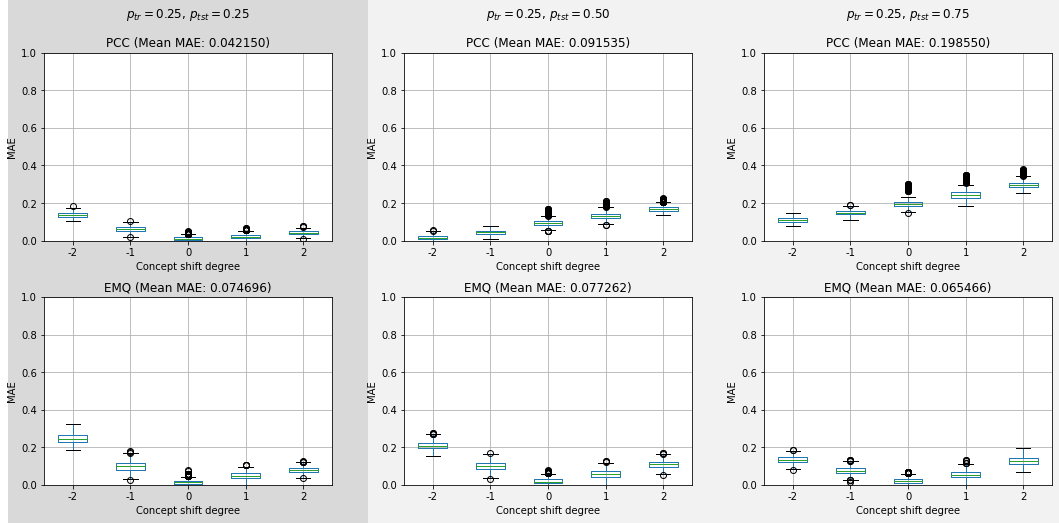

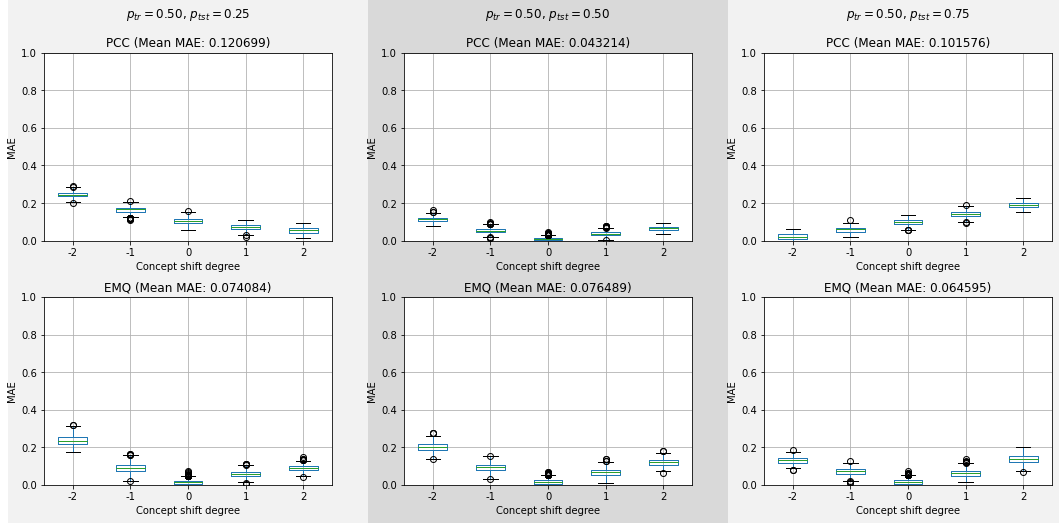

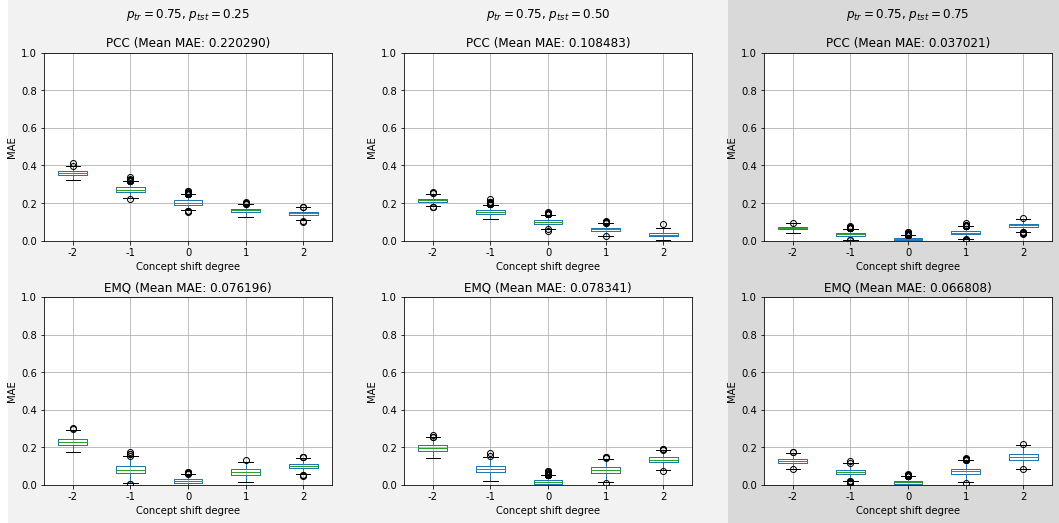

In [8]:
quantificators = ["PCC", "EMQ"]

for i, p_train in enumerate(ps_train):
    fig = plt.figure(figsize=(15,8))
    subfigs = fig.subfigures(ncols=3,wspace=2)
    plt.subplots_adjust(hspace=0.3)

    for j, p_test in enumerate(ps_test):
        axs = subfigs[j].subplots(nrows=2)
        for k,quant_name in enumerate(quantificators):
            exp_id = "%s_%f_%f" % (quant_name,p_train,p_test)
            results = results_dict[quant_name]
            results = results.loc[(results['p_test'] == p_test) & (results['p_train'] == p_train)]
            axs[k].set_ylim(0, 1)
            axs[k].set_ylabel(error)
            results.boxplot(ax=axs[k],column='MAE',by='cut_points')
            axs[k].set_xlabel("Concept shift degree")
            axs[k].set_title("%s (Mean %s: %f)"  % (quant_name,error,mean_error_methods[exp_id]))
        subfigs[j].suptitle('$p_{tr}=%.2f$, $p_{tst}=%.2f$' % (p_train,p_test))
        if p_train==p_test:
            subfigs[j].set_facecolor('0.85')
        else:
            subfigs[j].set_facecolor('0.95')

    plt.savefig(os.path.join(export_dir,"images/conceptsummary_{}.pdf".format(p_train)),format='pdf')
    plt.savefig(os.path.join(export_dir,"images/conceptsummary_{}.png".format(p_train)),format='png')

## Main tables for concept shift in the paper (version with AE)

This table has the results for concept shift. It is meant to be in the main paper.

In [19]:
from utils.wilcoxon import wilcoxon_test

quantificators = ["CC", "ACC", "PCC", "PACC", "DyS", "EMQ"]
global_results = {}
for i, p_train in enumerate(ps_train):
    columns = pd.MultiIndex.from_product([["p_test={}".format(p_test) for p_test in ps_test],quantificators])
    global_results[p_train] = pd.DataFrame(columns = columns,index=[-2,-1,0,1,2])
    for i, p_test in enumerate(ps_test):
        for k,quant_name in enumerate(quantificators):
            exp_id = "%s_%f_%f" % (quant_name,p_train,p_test)
            results = results_dict[quant_name]
            results = results.loc[(results['p_test'] == p_test) & (results['p_train'] == p_train)]
            results = results.groupby(by=['cut_points'])['MAE'].mean()
            global_results[p_train].loc[:, (["p_test={}".format(p_test)], [quant_name])] = results

global_results_style = {}
for p_train in ps_train:
    global_results_style[p_train] = global_results[p_train].style.format('{:.3f}')

for p_train in ps_train:
    for p_test in ps_test:
        #We want to make a statistical test for each row, to compare methods for the same degree of covariate shift
        for _,r in global_results[p_train].loc[:, (["p_test={}".format(p_test)])].iterrows():
            #compute the best method for this experiment
            cut_points = r.name
            best = r.index[r.argmin()]
            p_test = float(best[0][7:])
            best_method = best[1]
            #print("Computing statistical test for experiment covariate degree=%f, p_test=%s. Winner method %s" % (covariate_measure,p_test,best_method))
            #Get data for the winner method
            results_best = results_dict[best_method].loc[(results_dict[best_method]['p_test']==p_test) & (results_dict[best_method]['p_train']==p_train) & (results_dict[best_method]['cut_points']==cut_points),'error'].to_numpy()
            #We need to get all the rows in results that matches this experiment for each method
            for quant_name in quantificators:
                if quant_name!=best_method:
                    #print("Comparing %s with %s" % (best_method,quant_name))
                    results_method = results_dict[quant_name].loc[(results_dict[quant_name]['p_test']==p_test) & (results_dict[quant_name]['p_train']==p_train) & (results_dict[quant_name]['cut_points']==cut_points),'error'].to_numpy()
                    global_results_style[p_train].set_properties(subset=(cut_points, (best[0],quant_name)),**wilcoxon_test(results_best,results_method))


for p_train in ps_train:
    print("Table for p_train=%.2f" % p_train)
    for p_test in ps_test:
        global_results_style[p_train] = global_results_style[p_train].highlight_min(axis=1,props='textbf:--rwrap;',subset=(["p_test={}".format(p_test)]))
        if p_test == p_train:
            global_results_style[p_train] = global_results_style[p_train].set_properties(cellcolor="{verylightgray}", subset=(["p_test={}".format(p_test)]))
    display(global_results_style[p_train])
    columns = 'r'*len(quantificators)
    latex_code = global_results_style[p_train].to_latex(hrules=True,multicol_align='c',column_format='l|'+columns+'|'+columns+'|'+columns)
    latex_code = latex_code.replace(' 0.',' .').replace('{0.','{.')
    for p_test in ps_test:
        latex_code = latex_code.replace("p_test=%g" % p_test,"$p_{tst}=%g$" % p_test)
    with open(os.path.join(export_dir,'tables/concept_table_{}.tex'.format(p_train)), 'w') as f:
        f.write(latex_code)

Table for p_train=0.25


Table for p_train=0.50


Table for p_train=0.75
